In [9]:
import islpy as isl
from islplot_support import get_set_list, get_umap_list, plot_usets, plot_umaps
from latex_op import display_latex, print_latex

# Modeling memory accesses

## Access Relations
Each statement instance may access one or more variables, scalars or arrays.
If the array subscripts are affine forms of loop iterators and structure parameters,
one can define a Presburger relation that associates statement instances to the array elements they access.
Scalars are usually considered as zero-dimensional arrays in the polyhedral model for the sake of consistency.

Consider the polynomial multiplication kernel
```c
double X[100], Y[100], Z[200];
double zero = 0.;

for (int i = 0; i <= 200; ++i)
S:  Z[i] = zero;
for (int i = 0; i <= 100; ++i)
    for (int j = 0; j <= 100; ++j)
T:      Z[i + j] += A[i] * B[j];
```

Using only syntactic terms, we can say that statement `S` accesses array `Z`.
However, each individual *instance* $\mathtt{S}(i)$ only accesses one array element, `Z[i]`.
This can be encoded by a relation 

$$
\{ \mathtt{S}(i) \rightarrow \mathtt{Z}(a): a = i \}
$$

Furthermore, we know the size of the array `Z` so we can define constraints on $a$ that avoid out-of-memory accesses,
$$
\{ \mathtt{Z}(a): 0 \leq a \leq 200 \}
$$
At the same time, the iteration domain of `S` is
$$
\{ \mathtt{S}(i): 0 \leq i \leq 200 \}
$$
To plug these constraints into the access relation, we can intersect its *domain* with the iteration domain and its *range* with the array size constraint set.

In [10]:
A_S_Z = isl.Map("{S[i] -> Z[a]: a = i}")
D_S = isl.Set("{S[i]: 0 <= i <= 200}")
C_Z = isl.Set("{Z[a]: 0 <= a <= 200}")
A_S_Z = A_S_Z.intersect_domain(D_S).intersect_range(C_Z)
display_latex(A_S_Z)

<IPython.core.display.Math object>

The constraints on $a$ disappeared because of the *isl* simplification process.
Since $a = i$ the constraints hold simultaneously for both $a$ and $i$.

Scalars do not have subscripts, so they appear as zero-dimensional vectors in the range of access relation.
However, the range still has a name to tell scalars apart.  For example, all instances of `S` access the scalar `zero`,
$$ 
\{ \mathtt{S}(i) \rightarrow \mathtt{zero}(): 0 \leq i \leq 200 \} 
$$
The additional constraints on $i$ come from the iteration domain of `S`.

In [11]:
A_S_zero = isl.Map("{S[i] -> zero[]:}")
A_S_zero = A_S_zero.intersect_domain(D_S)
display_latex(A_S_zero)

<IPython.core.display.Math object>

Finally, it is possible to combine the access relations to different arrays into a single union map that describes all accesses of a statement.

In [12]:
A_S = isl.UnionMap(A_S_Z).union(A_S_zero)
display_latex(A_S)

<IPython.core.display.Math object>

Because we want to ensure the order of *reads* and *writes*, we can differentiate between access types by defining separate unions of access relations..
Some relations may appear in both, in case where the statement both reads and writes the same variable.

### Question
Define the map `A_T_Z` that connects instances of the statement `T` to elements of the array `Z`, then print it.

In [13]:
#!Solution
A_T_Z = isl.Map("{T[i,j] -> Z[a]: a = i + j}")
display_latex(A_T_Z)

<IPython.core.display.Math object>

### Question
Define the union maps `A_T_reads` and `A_T_writes` that map instances of the statement `T` to elements of *all* arrays they read and write, respectively.  Print them.

In [14]:
#!Solution
A_T_reads = isl.UnionMap("{T[i,j] -> Z[a]: a = i + j; T[i,j] -> X[a]: a = i; T[i,j] -> Y[a]: a = j}")
A_T_writes = isl.UnionMap("{T[i,j] -> Z[a]: a = i + j}")
display_latex(A_T_reads)
display_latex(A_T_writes)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Detecting Out-of-Bounds Accesses
By combining the iteration domain and the array size sets, one can detect out of bounds accesses.
Consider the following code
```c
double A[99];
for (int i = 0; i <= 99; i++)
X:  A[i+1] = 0.;
```
The access relation is based on the equality \$$ a = i + 1 \$$.
We first intersect its domain with the iteration domain of `S` and then its range with the size constraints on `A`.
The resulting relation contains all the *access instances*, i.e. pairs of statement instances and array elements, that are within the array extent.
Subtracting this relation from the relation only constrained by the domain gives us the relation of *invalid accesses*,
which shows which statement instance accesses which out-of-bounds array element.

In [15]:
A_X_A = isl.Map("{X[i]->A[a]: a = i+1}")
C_A = isl.Set("{A[i]: 0 <= i <= 99}")
D_X = isl.Set("{X[i]: 0 <= i <= 99}")
correct = A_X_A.intersect_domain(D_X).intersect_range(C_A)
incorrect = A_X_A.intersect_domain(D_X).subtract(correct)
display_latex(incorrect)

<IPython.core.display.Math object>

In this case, the instance $X(99)$ performs a one-past-end access to `A`.
This can be fixed, for example, by using strict comparison in the loop upper bound, `i < 99`.

### Question
Verify that the fix is correct, i.e. that the map of incorrect accesses is empty.

In [17]:
#!Solution
A_X_A = isl.Map("{X[i]->A[a]: a = i+1}")
C_A = isl.Set("{A[i]: 0 <= i <= 99}")
D_X = isl.Set("{X[i]: 0 <= i < 99}")
correct = A_X_A.intersect_domain(D_X).intersect_range(C_A)
incorrect = A_X_A.intersect_domain(D_X).subtract(correct)
display_latex(correct)
display_latex(incorrect)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

The equation $1 = 0$ is false.
In Presburger sets notation, it is used to express an empty set without loosing the name and dimension information.

## Potentially Dependent Instances
Let us first define the *inverse* access relation, which maps array elements to statement instances that access these elements.
Given the original access relation
$$ 
\mathcal{A}_{\mathtt{S} \rightarrow \mathtt{Z}} = \{ \mathtt{S}(i) \rightarrow \mathtt{Z}(a):
    a = i \wedge 0 \leq a,i \leq 200 \} 
$$
the inverse relation is defined by the *same constraints* but with domain and range spaces are swapped,
$$
\mathcal{A}_{\mathtt{S} \rightarrow \mathtt{Z}}^{-1} = \{ \mathtt{Z}(a) \rightarrow \mathtt{S}(i):
    a = i \wedge 0 \leq a,i \leq 200 \} 
$$
*isl* can compute inverse relations using

In [18]:
A_S_Z_inv = A_S_Z.reverse()
display_latex(A_S_Z_inv)

<IPython.core.display.Math object>

If two statement instances access the *same* array element, they may interfere with each other.
For example, one instance may write the value that is later read by another instance.
(In absence of `volatile` qualifier, two instances that *read* the same element are not supposed to interfere.)
Translating this definition into relations, we need to define a map between statement instances that access the same array elements.
Using the access relation, we know which elements a statement instance access.
Using the inverse access relation, we know which (other) statement instances access an array element.
Combining the two relations and equating the array subscript parts will give us the relation between potentially dependent statement instances.

This can be achieved through relation composition,
$$ 
\mathcal{X} \circ \mathcal{Y} = \{ \pmb{x} \rightarrow \pmb{y} \mid
    \exists \pmb{z} : (\pmb{x},\pmb{z}) \in \mathcal{X} \wedge (\pmb{z},\pmb{y}) \in \mathcal{Y} \} 
$$
    
*isl* lets you compose relations by applying a relation to the range of another relation.
To compute instances of `S` that access the same elements of `Z`, proceed as follows

In [19]:
dep_S_Z = A_S_Z.apply_range(A_S_Z.reverse())
display_latex(dep_S_Z)

<IPython.core.display.Math object>

As a result, you obtained a map between instances of `S`.
In this case, it is essentially a constrained *identity* relation due to $i^\prime = i$ equality.
This means that different instances of `S` access different array elements.

### Question
Define a map `dep_S_zero` that connects instances of `S` accessing the `zero` variable.

In [20]:
#!Solution
dep_S_zero = A_S_zero.apply_range(A_S_zero.reverse())
display_latex(dep_S_zero)

<IPython.core.display.Math object>

Now you see that all instances of `S` are related to each other because all of them access the scalar value.
Yet they only read this value and never modify it and thus should not interfere with each other.

## Reads and Writes
Generally, only the cases where at least one access is a *write* are considered potentially dependent.
Therefore, one needs to separate read and write accesses into different relations.

Let us reproduce our running example with smaller sizes for illustrative purposes and after propagating the constant value `zero`.
```c
double X[10], Y[10], Z[20];

for (int i = 0; i <= 20; ++i)
S:  Z[i] = 0.;
for (int i = 0; i <= 10; ++i)
    for (int j = 0; j <= 10; ++j)
T:      Z[i + j] += A[i] * B[j];
```

As a side remark, for *isl*, the complexity depends on the number of constraints rather than the number of points in the set.

Because maps in a union can live in different spaces, one can define a map of all reads and all writes by combining individual access (union) maps from different statements.

### Question
Given the individual access relations below, define union maps `reads` and `writes` for the *entire SCoP*.

In [21]:
A_S_Z = isl.Map("{S[i]->Z[a]: a = i and 0 <= a,i <= 20}")
A_T_Z = isl.Map("{T[i,j]->Z[a]: a = i + j and 0 <= i,j <= 10 and 0 <= a <= 20}")
A_T_A = isl.Map("{T[i,j]->A[a]: a = i and 0 <= a <= 20 and 0 <= i,j <= 10}")
A_T_B = isl.Map("{T[i,j]->B[a]: a = j and 0 <= a <= 20 and 0 <= i,j <= 10}")

In [22]:
#!Solution
writes = isl.UnionMap(A_S_Z).union(A_T_Z)
reads = isl.UnionMap(A_T_Z).union(A_T_A).union(A_T_B)
display_latex(reads)
display_latex(writes)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Selecting one Write
To avoid a composition the case when read accesses are composed with read accesses, we must ensure that
`reads` does not appear simultaneously on both sides of the composition 
$$ 
(\mathtt{reads} \circ \mathtt{writes}^{-1}) \cup 
    (\mathtt{writes} \circ \mathtt{reads}^{-1}) \cup
    (\mathtt{writes} \circ \mathtt{writes}^{-1}) 
$$
Note that `writes` appears on the right hand side twice, so we can simplify the expression to
$$ 
((\mathtt{reads} \cup \mathtt{writes}) \circ \mathtt{writes}^{-1}) \cup (\mathtt{writes} \circ \mathtt{reads}^{-1}) 
$$

Let us compute the first part of the union.

In [24]:
reads_writes = reads.union(writes)
left_part = reads_writes.apply_range(writes.reverse())
display_latex(left_part)

<IPython.core.display.Math object>

### Question
Compute the second part of the union and the entire union.

In [25]:
#!Solution
right_part = writes.apply_range(reads.reverse())
union = left_part.union(right_part)
display_latex(union)

<IPython.core.display.Math object>

### Question:
Now compute separately the `two_reads` relation that connects statement instances that read the same elements.

In [26]:
#!Solution
two_reads = reads.apply_range(reads.reverse())
display_latex(two_reads)

<IPython.core.display.Math object>

Let's compare these relations.  Even if they are printed in a different order, `union` and `left_part` are exactly the same.

In [28]:
print(union.is_equal(left_part))

True


This happens because the `left_part` is in fact a subset of `right_part` in our case.
Because `T` both reads and writes the same element,
the pair 
$$ 
\mathtt{S}(i) \rightarrow \mathtt{T}(i',j=i-i') 
$$ 
will appear in both.

In [29]:
print(right_part.is_subset(left_part))

True


Therefore, we could not just compute the overall set of potentially dependent statement pairs and then subtract
those with two reads.  If the same relation comes from two writes, it would also disappear!

### Question
Compute the relation between pairs of statement instances using both reads and writes,
subtract `two_reads` from it and check that it is indeed only a subset of `union`.

In [30]:
#!Solution
all_pairs = reads_writes.apply_range(reads_writes.reverse())
all_pairs = all_pairs.subtract(two_reads)
print(all_pairs.is_equal(union))
print(all_pairs.is_subset(union))

False
True


## Visualizing Potentially Dependent Instances
Let us constraint ourselves only to the instances of `T`.
We can use the fact that *isl* maps are *named* to select part of the union map.

<IPython.core.display.Math object>

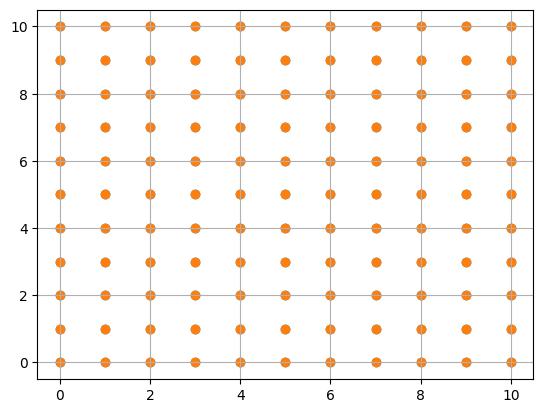

In [31]:
T_only = isl.Map("{T[i,j]->T[i,j]:}")
union = union.intersect(T_only)
display_latex(union)
plot_umaps(get_umap_list(union))

As you may see, each statement instance is related to *itself* and to one or multiple instances on the same diagonal.

### Question 
Define a map `left_42` that contains only the pairs where $\mathtt{T}(4,2)$ is on the left,
and a map `right_42` that contains only the pairs where it is on the right.

*Hint*: map domain and range are sets and can be acted upon.

In [32]:
#!Solution
left_42 = union.intersect_domain(isl.Set("{T[i,j]: i = 4 and j = 2}"))
right_42 = union.intersect_range(isl.Set("{T[i,j]: i = 4 and j = 2}"))

Let's compare these relations graphically.

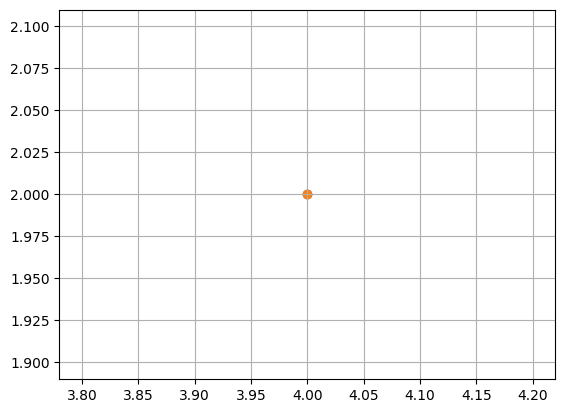

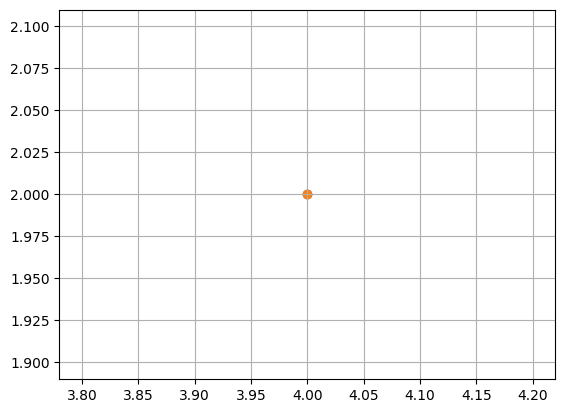

In [33]:
#!Solution
plot_umaps(get_umap_list(left_42))
plot_umaps(get_umap_list(right_42))

As you may see, the two relations are identical.
This is again due to the only access to `Z[i+j]` being both read and write.
The statement instance is connected to all other statement instances that access the same data.

However, it does not necessarily create a *dependence*.  For example, depending on itself does not fully make sense.
For two statement instances to be *dependent*, one of them should be executed *before* another.
That is, the first statement either produces some data necessary for the second one, or uses some data that would be overwritten by the second one.
Dependence computation requires knowing the *order* of statement execution.

### Question
Given the following code, compute and visualize pairs of statements that access the same array element,
and at least one of the accesses is a write.
*Hint:* use disjunction to encode different subscripts in different references to the same array.

```c
for (i = 0; i < 6; ++i)
  for (j = 0; j < 5; ++j)
S1: X[i][j] = i * j;
for (i = 8; i < 13; ++i)
  for (j = 11; j < 15; ++j)
S2: Y[i][j] = X[i - 8][j - 10] - X[i - 7][j - 11];
```

<IPython.core.display.Math object>

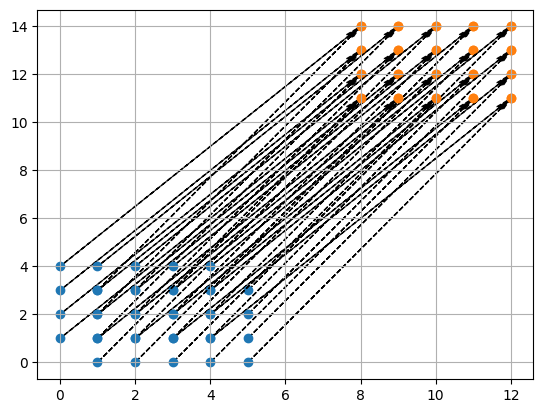

In [34]:
#!Solution
domain = isl.UnionSet("{S1[i,j]: 0 <= i < 6 and 0 <= j < 5; S2[i,j]: 8 <= i < 13 and 11 <= j < 15}")
writes = isl.UnionMap("{S1[i,j] -> X[a,b]: a = i and b = j; S2[i,j]->Y[a,b]: a = i and b = j}")
reads = isl.UnionMap("{S2[i,j] -> X[a,b]: (a = i - 8 and b = j - 10) or (a = i - 7 and b = j - 11)}")
writes = writes.intersect_domain(domain)
reads = reads.intersect_domain(domain)
deps = writes.apply_range(reads.reverse())
display_latex(deps)
plot_umaps(get_umap_list(deps))

### Question
Select *sample* instances of `S1` and `S2` and plot the instances of other statement that access the same array element.

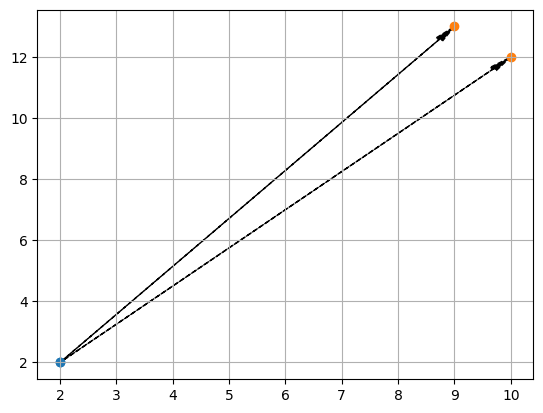

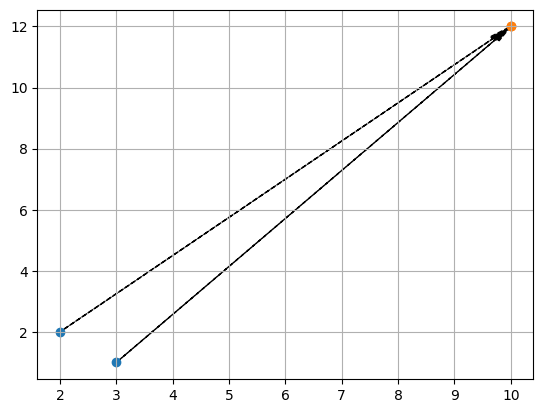

In [37]:
#!Solution
point_22 = isl.Set("{S1[i,j]: i = 2 and j = 2}")
point_1012 = isl.Set("{S2[i,j]: i = 10 and j = 12}")
sinks = deps.intersect_domain(point_22)
sources = deps.intersect_range(point_1012)

plot_umaps(get_umap_list(sinks))
plot_umaps(get_umap_list(sources))